In [100]:
%matplotlib inline
import utils
import os
import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
from sklearn import preprocessing
from sklearn.preprocessing import label_binarize
import librosa
import librosa.display
import missingno as msno 
%matplotlib inline
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, StandardScaler, RobustScaler
# importing warning in order to ignore them
import warnings 
warnings.filterwarnings('always')   #suppresses all warnings
warnings.filterwarnings('ignore')

In [101]:
# Directory where mp3 are stored.
AUDIO_DIR = os.environ.get('AUDIO_DIR')

tracks= utils.load("/Users/david/Desktop/DM2 project/fma_metadata/tracks.csv")
genres= utils.load("/Users/david/Desktop/DM2 project/fma_metadata/genres.csv")
features= utils.load("/Users/david/Desktop/DM2 project/fma_metadata/features.csv")
echonest= utils.load("/Users/david/Desktop/DM2 project/fma_metadata/echonest.csv")

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, genres.shape, features.shape, echonest.shape

((106574, 52), (163, 4), (106574, 518), (13129, 249))

In [102]:
regr_tracks=tracks.copy()

In [103]:
tracks_cut=['album','artist']
tracks.drop(tracks_cut,axis=1,inplace=True)
tracks.shape

(106574, 22)

In [104]:
tracks=tracks.droplevel(0,axis=1)

In [105]:
tracks_cut=['composer','comments', 'date_created','date_recorded',
            'license','number','title','language_code',
            'publisher', 'tags','information','lyricist','genres','genres_all',
            'favorites','listens','interest','bit_rate', 'duration']
tracks.drop(tracks_cut,axis=1,inplace=True)

In [106]:
df_target=features[['spectral_rolloff','spectral_centroid']]

In [107]:
df_target=df_target.droplevel(0,axis=1)

In [108]:
df_target.columns=['roll_kurtosis','roll_max','roll_mean','roll_median','roll_min','roll_skew','roll_std',
                   'centr_kurtosis','centr_max','centr_mean','centr_median','centr_min','centr_skew','centr_std']
                   
                   #'bandw_kurtosis','bandw_max','bandw_mean','bandw_median','bandw_min','bandw_skew','bandw_std']
df_target.head()

,roll_kurtosis,roll_max,roll_mean,roll_median,roll_min,roll_skew,roll_std,centr_kurtosis,centr_max,centr_mean,centr_median,centr_min,centr_skew,centr_std
track_id,,,,,,,,,,,,,,
2,0.840540,9410.009766,3267.804688,3143.847656,0.000000,0.347372,1300.729736,2.406808,5514.049805,1639.583252,1503.496704,0.000000,1.079815,719.770508
3,2.379145,10002.172852,3514.619629,3413.012695,0.000000,1.118952,1650.357788,3.519866,6288.426758,1763.012451,1517.993652,0.000000,1.652693,972.758423
5,-0.238572,9442.309570,2773.931885,2863.916016,0.000000,0.266975,1323.465210,1.322586,5648.614746,1292.958130,1186.514038,0.000000,0.937101,665.319275
10,3.619834,10056.005859,2603.491943,2002.587891,0.000000,1.800220,1524.401245,9.729688,5739.394531,1360.028687,1180.966797,0.000000,2.523783,668.700806
20,-0.744805,9496.142578,4201.346191,4166.674805,75.366211,0.160345,1495.297119,2.177669,5540.209961,1732.971802,1640.781128,123.611168,0.960959,481.929871


In [109]:
df=pd.merge(tracks,df_target, on='track_id')

In [110]:
df.drop(index=df[df.subset=='large'].index, inplace=True)

# Pre-processing

In [111]:
train = df.index[df['split'] == 'training']
val = df.index[df['split'] == 'validation']
test = df.index[df['split'] == 'test']

In [112]:
#copy dataframe
df_enc=df.copy()

In [113]:
df_enc

,split,subset,genre_top,roll_kurtosis,roll_max,roll_mean,roll_median,roll_min,roll_skew,roll_std,centr_kurtosis,centr_max,centr_mean,centr_median,centr_min,centr_skew,centr_std
track_id,,,,,,,,,,,,,,,,,
2,training,small,Hip-Hop,0.840540,9410.009766,3267.804688,3143.847656,0.000000,0.347372,1300.729736,2.406808,5514.049805,1639.583252,1503.496704,0.000000,1.079815,719.770508
3,training,medium,Hip-Hop,2.379145,10002.172852,3514.619629,3413.012695,0.000000,1.118952,1650.357788,3.519866,6288.426758,1763.012451,1517.993652,0.000000,1.652693,972.758423
5,training,small,Hip-Hop,-0.238572,9442.309570,2773.931885,2863.916016,0.000000,0.266975,1323.465210,1.322586,5648.614746,1292.958130,1186.514038,0.000000,0.937101,665.319275
10,training,small,Pop,3.619834,10056.005859,2603.491943,2002.587891,0.000000,1.800220,1524.401245,9.729688,5739.394531,1360.028687,1180.966797,0.000000,2.523783,668.700806
134,training,medium,Hip-Hop,0.488314,9442.309570,2462.616943,2099.487305,0.000000,0.750207,1406.506592,2.208298,5518.117188,1257.696289,1118.902588,0.000000,1.120293,718.104797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155297,training,medium,Instrumental,32.431602,9883.740234,1189.471436,1033.593750,204.565430,5.377576,1276.645996,55.303261,8601.571289,750.424744,636.640259,220.715759,7.249722,919.452454
155298,training,medium,Folk,7.010324,9991.406250,1504.343750,1313.525391,0.000000,2.150454,1135.410767,18.339352,6361.462402,770.230652,676.175720,0.000000,3.141982,449.027496
155306,training,medium,Folk,7.370663,9453.076172,1562.254517,1238.159180,193.798828,2.179922,1146.488037,10.664659,5597.755859,780.710510,650.279541,193.229736,2.397812,472.045807


In [114]:
le=LabelEncoder()
ple= preprocessing.LabelEncoder()
df_enc['genre_top']=le.fit_transform(df_enc['genre_top'])

In [115]:
df_enc['genre_top'].unique()

array([ 7, 12, 13,  6,  5, 10,  4,  9, 14,  0, 15,  2,  1, 11,  8,  3])

In [116]:
replace_values=[ 7, 12, 13,  6,  5, 10,  4,  9, 14,  0, 15,  2,  1,  8,  3]
df_enc['genre_top']=df_enc['genre_top'].replace(replace_values,0)
df_enc['genre_top']=df_enc['genre_top'].replace(11,1)

In [117]:
y_train = df_enc['genre_top'].loc[df_enc['split'] == 'training']
y_val = df_enc['genre_top'].loc[df_enc['split'] == 'validation']
y_test = df_enc['genre_top'].loc[df_enc['split'] == 'test']
y_train.shape, y_val.shape, y_test.shape

((19922,), (2505,), (2573,))

In [118]:
X=df_enc.drop('genre_top',axis=1)

In [119]:
X_train = X.loc[X['split'] == 'training']
X_val = X.loc[X['split'] == 'validation']
X_test = X.loc[X['split'] == 'test']
X_train.shape, X_val.shape, X_test.shape

((19922, 16), (2505, 16), (2573, 16))

In [120]:
X_train, y_train = shuffle(X_train, y_train, random_state=42)

In [121]:
cut_columns=['split','subset',
             'roll_max','roll_mean','roll_median','roll_min','roll_skew','roll_std'
            ,'centr_kurtosis','centr_max','centr_mean','centr_median','centr_min','centr_skew','centr_std']
X_train.drop(cut_columns,axis=1,inplace=True)
X_val.drop(cut_columns,axis=1,inplace=True)
X_test.drop(cut_columns,axis=1,inplace=True)

In [122]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
#normalize data with Robust scaler
scaler = RobustScaler()
scaler.fit_transform(X_train)
scaler.fit_transform(X_val)
scaler.fit_transform(X_test)

array([[ 1.39836398],
       [ 0.03145794],
       [ 0.47839267],
       ...,
       [-0.26400148],
       [ 0.98246302],
       [-0.25908031]])

In [123]:
#task:rimuovere l'1% degli outliers:
outlier_fraction = 0.1
#andremo a cercare slamente l'1% degli outliers e li rimuoveremo o sostituiremo in seguito

In [124]:
from pyod.models.abod import ABOD
abod=ABOD(contamination=outlier_fraction)
abod.fit(X_train)
abod_anomalies = abod.predict(X_train)
np.unique(abod_anomalies, return_counts=True)
# select all rows that are not outliers
abod_inlier= abod_anomalies!=1
abod_outliers= X_train[abod_anomalies==1]
X_train.shape
# select all rows that are not outliers
abod_inlier= abod_anomalies!=1
abod_outlier= X_train[abod_anomalies==1]
X_train1, y_train1 = X_train.iloc[abod_inlier, :], y_train.iloc[abod_inlier]
# summarize the shape of the updated training dataset
print(X_train1.shape, y_train1.shape)

(17984, 1) (17984,)


In [125]:
from sklearn.ensemble import IsolationForest
iso = IsolationForest(max_samples=100,random_state=42, contamination=0.1) 
iso.fit(X_train)
if_anomalies=iso.predict(X_train)
np.unique(if_anomalies,return_counts=True)
# select all rows that are not outliers
if_inlier=if_anomalies!=-1
if_outlier=X_train[if_anomalies==-1]
X_train4, y_train4 = X_train.iloc[if_inlier, :], y_train.iloc[if_inlier]
# summarize the shape of the updated training dataset
print(X_train4.shape, y_train4.shape)

(17929, 1) (17929,)


In [126]:
if_indexes=if_outlier.index.tolist()
abod_indexes=abod_outlier.index.tolist()
#comparison if with abod
count_if_abod=0
for i in set(if_indexes).intersection(set(abod_indexes)):
    count_if_abod= count_if_abod+1
print(count_if_abod) 

1637


In [127]:
X_train_clean=X_train.copy()
y_train_clean=y_train.copy()
for index in set(if_indexes).intersection(set(abod_indexes)):
    X_train_clean.drop(index,inplace=True)
    y_train_clean.drop(index, inplace=True)
print('Dataset before outliers removed:',X_train.shape, y_train.shape)
print('Dataset cleaned:', X_train_clean.shape, y_train_clean.shape)

Dataset before outliers removed: (19922, 1) (19922,)
Dataset cleaned: (18285, 1) (18285,)


In [128]:
X_train=X_train_clean
y_train=y_train_clean
X_train.shape,y_train.shape

((18285, 1), (18285,))

In [129]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# REGRESSION PROBLEM

In [130]:
regr_tracks.shape

(106574, 52)

In [131]:
tracks_cut=['album','artist']
regr_tracks.drop(tracks_cut,axis=1,inplace=True)
regr_tracks.shape

(106574, 22)

In [132]:
regr_tracks=regr_tracks.droplevel(0,axis=1)

In [133]:
tracks_cut=['composer', 'date_created','date_recorded',
            'license','number','title','language_code',
            'publisher', 'tags','information','lyricist','genres','genres_all',
            'bit_rate','genre_top']
regr_tracks.drop(tracks_cut,axis=1,inplace=True)

In [134]:
regr_tracks

,split,subset,comments,duration,favorites,interest,listens
track_id,,,,,,,
2,training,small,0,168,2,4656,1293
3,training,medium,0,237,1,1470,514
5,training,small,0,206,6,1933,1151
10,training,small,0,161,178,54881,50135
20,training,large,0,311,0,978,361
...,...,...,...,...,...,...,...
155316,training,large,0,162,1,122,102
155317,training,large,0,217,1,194,165
155318,training,large,0,404,2,214,168


In [135]:
target_regr=features[['spectral_rolloff','spectral_centroid']]

In [136]:
target_regr=target_regr.droplevel(0,axis=1)

In [137]:
target_regr.columns=['roll_kurtosis','roll_max','roll_mean','roll_median','roll_min','roll_skew','roll_std',
                   'centr_kurtosis','centr_max','centr_mean','centr_median','centr_min','centr_skew','centr_std']
                   
                   #'bandw_kurtosis','bandw_max','bandw_mean','bandw_median','bandw_min','bandw_skew','bandw_std']
target_regr.head()

,roll_kurtosis,roll_max,roll_mean,roll_median,roll_min,roll_skew,roll_std,centr_kurtosis,centr_max,centr_mean,centr_median,centr_min,centr_skew,centr_std
track_id,,,,,,,,,,,,,,
2,0.840540,9410.009766,3267.804688,3143.847656,0.000000,0.347372,1300.729736,2.406808,5514.049805,1639.583252,1503.496704,0.000000,1.079815,719.770508
3,2.379145,10002.172852,3514.619629,3413.012695,0.000000,1.118952,1650.357788,3.519866,6288.426758,1763.012451,1517.993652,0.000000,1.652693,972.758423
5,-0.238572,9442.309570,2773.931885,2863.916016,0.000000,0.266975,1323.465210,1.322586,5648.614746,1292.958130,1186.514038,0.000000,0.937101,665.319275
10,3.619834,10056.005859,2603.491943,2002.587891,0.000000,1.800220,1524.401245,9.729688,5739.394531,1360.028687,1180.966797,0.000000,2.523783,668.700806
20,-0.744805,9496.142578,4201.346191,4166.674805,75.366211,0.160345,1495.297119,2.177669,5540.209961,1732.971802,1640.781128,123.611168,0.960959,481.929871


In [138]:
df_regr=pd.merge(regr_tracks,target_regr, on='track_id')

In [139]:
df_regr.drop(index=df_regr[df_regr.subset=='large'].index, inplace=True)

In [140]:
a='listens'
b='favorites'

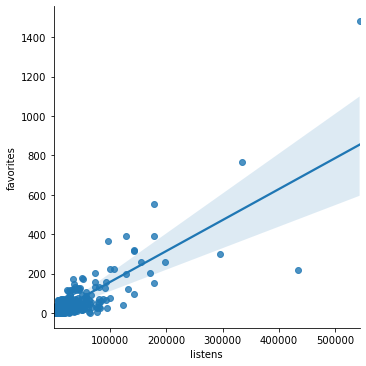

In [141]:
sns.lmplot(x=a,y=b, data=df_regr)

# Pre-processing

In [142]:
train = df_regr.index[df_regr['split'] == 'training']
val = df_regr.index[df_regr['split'] == 'validation']
test = df_regr.index[df_regr['split'] == 'test']

In [143]:
y_train = df_regr[b].loc[df_regr['split'] == 'training']
y_val = df_regr[b].loc[df_regr['split'] == 'validation']
y_test = df_regr[b].loc[df_regr['split'] == 'test']
y_train.shape, y_val.shape, y_test.shape

((19922,), (2505,), (2573,))

In [144]:
X=df_regr.drop(b,axis=1)

In [145]:
X_train = X.loc[X['split'] == 'training']
X_val = X.loc[X['split'] == 'validation']
X_test = X.loc[X['split'] == 'test']
X_train.shape, X_val.shape, X_test.shape

((19922, 20), (2505, 20), (2573, 20))

In [146]:
#per fare multiregressor con più x
df_multi_regr=df_regr.copy()

cut_columns_multi_regr=['split','subset',
            'roll_kurtosis','roll_max','roll_min','roll_skew','roll_mean','roll_median',
            'centr_kurtosis','centr_max','centr_mean','centr_median','centr_min','centr_skew',
            'centr_std','interest','duration','roll_std','comments']

X_train1=X_train.copy()
X_val1=X_val.copy()
X_test1=X_test.copy()

X_train1.drop(cut_columns_multi_regr,axis=1,inplace=True)
X_val1.drop(cut_columns_multi_regr,axis=1,inplace=True)
X_test1.drop(cut_columns_multi_regr,axis=1,inplace=True)

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
#normalize data with Robust scaler
scaler = RobustScaler()
scaler.fit_transform(X_train1)
scaler.fit_transform(X_val1)
scaler.fit_transform(X_test1)

scaler = StandardScaler()
scaler.fit_transform(X_train1)
scaler.fit_transform(X_val1)
scaler.fit_transform(X_test1)



array([[-0.10119983],
       [ 0.26257962],
       [-0.17658378],
       ...,
       [-0.05832088],
       [ 0.01689017],
       [ 0.09331152]])

In [147]:
#for plot 2d linear regressor
cut_columns_2d_regr=['split','subset',
            'roll_kurtosis','roll_max','roll_min','roll_skew','roll_mean','roll_median',
            'centr_kurtosis','centr_max','centr_mean','centr_median','centr_min','centr_skew',
            'centr_std','interest','duration','roll_std','comments']
#'roll_std',           
X_train.drop(cut_columns_2d_regr,axis=1,inplace=True)
X_val.drop(cut_columns_2d_regr,axis=1,inplace=True)
X_test.drop(cut_columns_2d_regr,axis=1,inplace=True)

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
#normalize data with Robust scaler
scaler = RobustScaler()
scaler.fit_transform(X_train)
scaler.fit_transform(X_val)
scaler.fit_transform(X_test)

scaler = StandardScaler()
scaler.fit_transform(X_train)
scaler.fit_transform(X_val)
scaler.fit_transform(X_test)

array([[-0.10119983],
       [ 0.26257962],
       [-0.17658378],
       ...,
       [-0.05832088],
       [ 0.01689017],
       [ 0.09331152]])

In [148]:
X_train, y_train = shuffle(X_train, y_train, random_state=42)

In [149]:
X_train.head()

,listens
track_id,
138917,390
55956,35768
33242,1492
76134,420
6669,627


In [150]:

reg=LinearRegression()
reg.fit(X_train,y_train)

LinearRegression()

In [151]:
y_pred=reg.predict(X_test)

### Second way 2D

Coefficients: [0.00130032]
Intercept: 0.42616081419835083
R2: 0.707
MSE: 267.181
MAE: 2.812
Coefficient of determination: 0.71


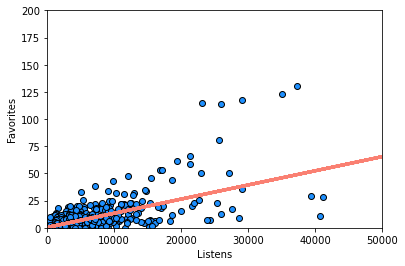

In [162]:
# The coefficients
print('Coefficients:', reg.coef_)
print('Intercept:', reg.intercept_)
# The mean squared error
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'% r2_score(y_test, y_pred))

plt.scatter(X_test, y_test, color='dodgerblue', edgecolors='k')
plt.plot(X_test, y_pred, color='salmon', linewidth=3)
plt.xlim([0,50000])
plt.ylim([0,200])
plt.xlabel('Listens')
plt.ylabel('Favorites')
plt.show()

In [153]:
x_values = list(sorted([v for v in X_test]))
y_values = y_pred[np.argsort(X_test)]

# LASSO

In [154]:
reg = Lasso()
reg.fit(X_train, y_train)
print('Coefficients: \n', reg.coef_)
print('Intercept: \n', reg.intercept_)

Coefficients: 
 [0.0013003]
Intercept: 
 0.4262044416616


In [155]:
y_pred = reg.predict(X_test)
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

R2: 0.707
MSE: 267.187
MAE: 2.812


# RIDGE

In [156]:
reg = Ridge()
reg.fit(X_train, y_train)
print('Coefficients: \n', reg.coef_)
print('Intercept: \n', reg.intercept_)

Coefficients: 
 [0.00130032]
Intercept: 
 0.42616081419835083


In [157]:
y_pred = reg.predict(X_test)
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

R2: 0.707
MSE: 267.181
MAE: 2.812
